# Sample Code to Run TS-LGB
This notebook shows how to use TS-LGB, a two-step algorithm for survival analysis with LightGBM.

## Load Data

In [160]:
# Prerequisite: pip install SurvSet
from SurvSet.data import SurvLoader

loader = SurvLoader()
df, _ = loader.load_dataset(ds_name="flchain").values()
print(df.head())

   pid  event  time  num_age  num_kappa  num_lambda  num_flc_grp  \
0    0      1    85       97       5.70       4.860           10   
1    1      1  1281       92       0.87       0.683            1   
2    2      1    69       94       4.36       3.850           10   
3    3      1   115       92       2.42       2.220            9   
4    4      1  1039       93       1.32       1.690            6   

   num_creatinine  num_sample_yr fac_sex  fac_chapter fac_sample_yr fac_mgus  
0             1.7           1997       F  Circulatory          1997        N  
1             0.9           2000       F    Neoplasms          2000        N  
2             1.4           1997       F  Circulatory          1997        N  
3             1.0           1996       F  Circulatory          1996        N  
4             1.1           1996       F  Circulatory          1996        N  


## Compute boundaries and label

In [161]:
import numpy as np

def compute_label(boundaries, num_risks, t, e):
    e = e.astype(int)
    idx = np.searchsorted(boundaries, t.reshape(-1, 1), side="right")
    idx = np.clip(idx, 1, len(boundaries) - 1)
    return (idx.reshape(-1) - 1) * num_risks + e

lb = df["time"].min()
ub = df["time"].max()
num_bin = 32
boundaries = np.linspace(lb, ub, num_bin+1)
label = compute_label(boundaries, 2, df["time"].values, df["event"].values)

## One-hot Encoding

In [162]:
from sklearn.preprocessing import LabelEncoder

cols_cat = []
for col in df.columns:
    if col.startswith("fac_"):
        cols_cat.append(col)

le = LabelEncoder()
for col in cols_cat:
    le = le.fit(df[col])
    df[col]=le.transform(df[col])
print(df.head())

   pid  event  time  num_age  num_kappa  num_lambda  num_flc_grp  \
0    0      1    85       97       5.70       4.860           10   
1    1      1  1281       92       0.87       0.683            1   
2    2      1    69       94       4.36       3.850           10   
3    3      1   115       92       2.42       2.220            9   
4    4      1  1039       93       1.32       1.690            6   

   num_creatinine  num_sample_yr  fac_sex  fac_chapter  fac_sample_yr  \
0             1.7           1997        0            1              2   
1             0.9           2000        0           12              5   
2             1.4           1997        0            1              2   
3             1.0           1996        0            1              1   
4             1.1           1996        0            1              1   

   fac_mgus  
0         0  
1         0  
2         0  
3         0  
4         0  


## Split dataset

In [163]:
from sklearn.model_selection import train_test_split

df_train, df_test, label_train, label_test = train_test_split(df, label, random_state=42, test_size=0.2) 
print(df_train.shape, df_test.shape)
print(label_train.shape, label_test.shape)

(6299, 13) (1575, 13)
(6299,) (1575,)


## Train model with LightGBM

In [164]:
import lightgbm as lgb

# drop the columns that are not needed
x_train = df_train.drop(columns=["pid", "time", "event"])
x_test = df_test.drop(columns=["pid", "time", "event"])

# train with LightGBM with parameters tuned for flchain dataset
lgb_model = lgb.LGBMClassifier(
    n_estimators = 279,
    max_depth = 3,
    min_child_samples = 6,
    num_leaves = 26,
    criterion = "log_loss",
    learning_rate = 0.007696701896574052,
    lambda_l1 = 3.7252491463357303e-05,
    random_state=0)
lgb_model.fit(x_train, label_train, categorical_feature=cols_cat)
y_pred = lgb_model.predict_proba(x_test)
print("y_pred", y_pred, y_pred.shape)

[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] lambda_l1 is set=3.7252491463357303e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7252491463357303e-05
[LightGBM] [Warning] Unknown parameter: criterion
[LightGBM] [Warning] lambda_l1 is set=3.7252491463357303e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7252491463357303e-05
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000380 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 644
[LightGBM] [Info] Number of data points in the train set: 6299, number of used features: 10
[LightGBM] [Info] Start training from score -5.570092
[LightGBM] [Info] Start training from score -3.969023
[LightGBM] [Info] Start training from score -5.975557
[LightGBM] [Info] Start training from score -4.417413
[LightGBM] [Info] Start training from score -5.914933
[LightGBM] [Info] Start training from score -4.670609
[LightG

In [165]:
from cenreg.distribution.linear import LinearCDF
from cenreg.model.cjd2F_np import integral

def fill_missing_pred(y_pred, classes, num_class):
    list_pred = []
    for i in range(num_class):
        not_found = True
        for j in range(len(classes)):
            if i == classes[j]:
                list_pred.append(y_pred[:, j])
                not_found = False
                break
        if not_found:
            list_pred.append(np.zeros(y_pred.shape[0]))
    return np.stack(list_pred, axis=1)

if len(lgb_model.classes_) < 2 * num_bin:
    y_pred = fill_missing_pred(y_pred, lgb_model.classes_, 2 * num_bin)

f_pred = y_pred.reshape(-1, num_bin, 2).transpose(0, 2, 1)

# Convert the output of LightGBM to the CDF for each risk
F_pred = integral(f_pred)

# Create a LinearCDF object with the predicted CDF for Event 1
t_dist = LinearCDF(boundaries, F_pred[:,1,:], apply_cumsum=False)

## Evaluate Model

In [171]:
import cenreg.metric.cdf
import cenreg.metric.cjd
import cenreg.metric.quantile

cjd_pred = f_pred.reshape(-1, num_bin * 2)
observed_times = df_test['time'].values
events = df_test["event"].astype(bool).values

# Compute Brier score on CJD representation
cjd_brier = cenreg.metric.cjd.brier(observed_times, events, 2, cjd_pred, boundaries)
print("CJD-Brier", cjd_brier.mean())

# Compute Logarithmic score on CDF representation
cjd_logarithmic = cenreg.metric.cjd.negative_loglikelihood(observed_times, events, cjd_pred, boundaries)
print("CJD-Logarithmic", cjd_logarithmic.mean())

# Compute KS calibration error on CDF representation
cjd_ks = cenreg.metric.cjd.kolmogorov_smirnov_calibration_error(observed_times, events, cjd_pred, boundaries)
print("CJD-KS", cjd_ks)

# Compute cen-log metric
nll = cenreg.metric.cdf.negative_loglikelihood(t_dist, observed_times, events)
print("Cen-log", nll.mean())

# Compute D-calibration
quantiles_cal = np.linspace(0.0, 1.0, 11)
dcal = cenreg.metric.quantile.d_calibration(t_dist, observed_times, events, quantiles_cal)
print("D-calibration", dcal)

# Compute KM-calibration
kmcal = cenreg.metric.cdf.km_calibration(t_dist, observed_times, events, boundaries)
print("KM-calibration", kmcal)


CJD-Brier 0.7080438254530048
CJD-Logarithmic 2.10570287056332
CJD-KS 0.2451358645482805
Cen-log 0.9940804829017664
D-calibration 0.0017511031246599993
KM-calibration 0.015751980114372285


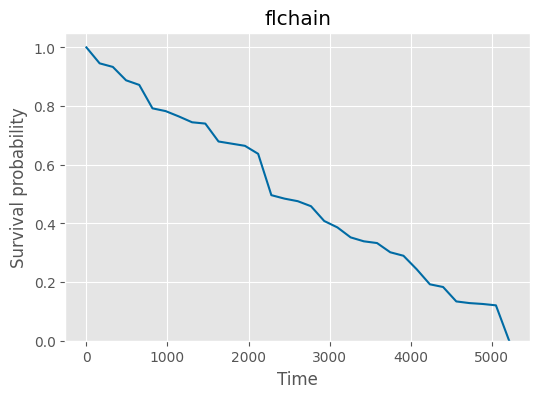

In [170]:
%matplotlib inline

import matplotlib.pyplot as plt

x = t_dist.boundaries
y = 1.0 - t_dist.cdf(x)

plt.style.use("tableau-colorblind10")
plt.figure(figsize=(6, 4))
plt.title("flchain")
plt.xlabel("Time")
plt.ylabel("Survival probability")
plt.ylim(0.0, 1.05)
plt.plot(x, y[50])  # Plot the 50-th survival function
plt.show()